In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/df-shap/df_shap.csv
/kaggle/input/datath/datasetX3_reverse.pt
/kaggle/input/df-main/df_main.csv


In [2]:
import torch

In [3]:
from transformers import pipeline

pipe = pipeline("text-classification", model="phoner45/wangchan-sentiment-thai-text-model")

2025-05-05 12:02:46.394851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746446566.685009      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746446566.765188      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/421M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/905k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/365 [00:00<?, ?B/s]

Device set to use cpu


In [4]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

tokenizer = AutoTokenizer.from_pretrained("phoner45/wangchan-sentiment-thai-text-model")
model = AutoModel.from_pretrained("phoner45/wangchan-sentiment-thai-text-model")

Some weights of CamembertModel were not initialized from the model checkpoint at phoner45/wangchan-sentiment-thai-text-model and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
df = pd.read_csv("/kaggle/input/df-main/df_main.csv")
df.head(2)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,img_id,sentences,text_length,word_list,Negative,Neutral,Positive,has_cta,ctr,ctr_group
0,0.708480,0.759826,0.449038,0.476864,0.791149,0.541827,0.389004,0.282455,0.802612,0.318787,...,c7e254ff6e829bbd379c791c06dba26a,วันนี - 14 มีนาคม 2568 รีบด่วน 400 web hosting,46,"['วัน', 'นี', ' ', '-', ' ', '14', ' ', 'มีนาค...",0,16,0,False,0.000000,Low
1,0.733801,0.642118,0.425671,0.490838,0.708187,0.605140,0.204538,0.374215,0.633562,0.262923,...,310f05853aa67594eadcecfaeab260c9,แฟลชเซล มาก่อน ได้ก่อน 899 12 00 น.,35,"['แฟลช', 'เซ', 'ล', ' ', 'มา', 'ก่อน', ' ', 'ไ...",0,1,0,False,0.016482,Low


In [6]:
def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        output = model(**tokens)
    embedding = output.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

In [7]:
# df['sentence_embeddings'] = df['sentences'].apply(get_bert_embedding)

In [8]:
df['word_embeddings'] = df['word_list'].apply(get_bert_embedding)

In [10]:
# df['combined_embeddings'] = df.apply(lambda row: np.concatenate([row['sentence_embeddings'], row['word_embeddings']]), axis=1)

4. การใช้ Combined Embeddings กับ Latent Features ของรูปภาพ
หลังจากนั้น, คุณสามารถใช้ combined_embeddings ที่ได้จากข้อความมารวมกับ latent features ของรูปภาพ (จาก VAE หรือโมเดลภาพที่คุณใช้) เพื่อเป็น input ในโมเดล multimodal (เช่น Neural Network หรือ XGBoost) เพื่อทำนาย CTR_group หรือผลลัพธ์อื่น ๆ:

In [11]:
image_features = df.filter(like='feature_').values

In [12]:
image_features.shape

(1115, 128)

In [13]:
# text_embeddings = np.vstack(
#     df.apply(lambda row: np.concatenate([row['sentence_embeddings'], row['word_embeddings']]), axis=1)
# )

In [14]:
meta_features = df[['has_cta', 'Positive', 'Negative', 'Neutral']].values
word_array = np.vstack(df['word_embeddings'].values)

In [15]:
combined_features = np.hstack([image_features, word_array, meta_features])

In [16]:
combined_features.shape

(1115, 900)

In [24]:
# df['ctr_group'] = df['ctr_group'].map({'Low': 0, 'High': 1})

In [25]:
df['ctr_group'].value_counts()

ctr_group
0    558
1    557
Name: count, dtype: int64

In [26]:
from sklearn.model_selection import train_test_split, cross_val_score

X = combined_features
y = df['ctr_group']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [27]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((892, 900), (892,), (111, 900), (111,), (112, 900), (112,))

In [28]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [29]:
print(type(X_train))
print(np.array(X_train).shape)

<class 'numpy.ndarray'>
(892, 900)


In [30]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [31]:
type(dtrain)

xgboost.core.DMatrix

In [32]:
params = {
    'objective': 'binary:logistic',  # Classification binary
    'eval_metric': 'logloss',        # ใช้ logloss เป็น metric
    'max_depth': 10,                 # ความลึกสูงสุดของต้นไม้
    'learning_rate': 0.05,           # อัตราการเรียนรู้
    'n_estimators': 2000,            # จำนวนต้นไม้
    'subsample': 0.8,                # ใช้ 80% ของข้อมูลในการฝึก
    'colsample_bytree': 0.8,         # ใช้ 80% ของฟีเจอร์ในการฝึก
    'gamma': 0.1,                    # การควบคุมการ split ของต้นไม้
    'scale_pos_weight': 1.0          # ถ้ามี imbalance ใน class
}

In [33]:
evals = [(dtrain, 'train'), (dval, 'eval')]

In [34]:
num_round = 1000  
early_stopping_rounds = 50  

In [35]:
evals_result = {}

In [36]:
bst = xgb.train(
    params, 
    dtrain, 
    num_round, 
    evals=evals, 
    early_stopping_rounds=early_stopping_rounds,
    evals_result=evals_result,  
    verbose_eval=True
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:07:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-logloss:0.65452	eval-logloss:0.66410
[1]	train-logloss:0.61964	eval-logloss:0.64237
[2]	train-logloss:0.58846	eval-logloss:0.61912
[3]	train-logloss:0.55758	eval-logloss:0.59386
[4]	train-logloss:0.52967	eval-logloss:0.57418
[5]	train-logloss:0.50302	eval-logloss:0.55617
[6]	train-logloss:0.47911	eval-logloss:0.53914
[7]	train-logloss:0.45608	eval-logloss:0.52485
[8]	train-logloss:0.43503	eval-logloss:0.51039
[9]	train-logloss:0.41510	eval-logloss:0.49760
[10]	train-logloss:0.39652	eval-logloss:0.47923
[11]	train-logloss:0.37848	eval-logloss:0.46899
[12]	train-logloss:0.36129	eval-logloss:0.45888
[13]	train-logloss:0.34565	eval-logloss:0.44558
[14]	train-logloss:0.33078	eval-logloss:0.43628
[15]	train-logloss:0.31717	eval-logloss:0.42853
[16]	train-logloss:0.30353	eval-logloss:0.41862
[17]	train-logloss:0.29079	eval-logloss:0.40946
[18]	train-logloss:0.27860	eval-logloss:0.40146
[19]	train-logloss:0.26762	eval-logloss:0.39188
[20]	train-logloss:0.25719	eval-logloss:0.38467
[2

In [37]:
y_pred = bst.predict(dval)
y_pred_binary = (y_pred > 0.5).astype(int)  # binary class

In [38]:
accuracy = accuracy_score(y_val, y_pred_binary)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.8739


In [39]:
print(f"Best Iteration: {bst.best_iteration}")
print(f"Best Logloss (Training): {bst.best_score}")

Best Iteration: 78
Best Logloss (Training): 0.24778468291031885


In [40]:
train_logloss = evals_result['train']['logloss']
val_logloss = evals_result['eval']['logloss']

In [41]:
import matplotlib.pyplot as plt

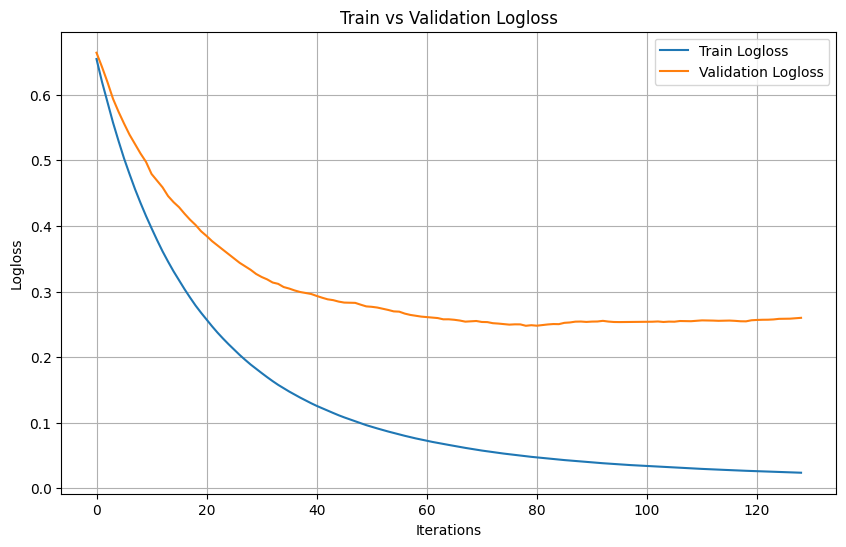

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(train_logloss, label='Train Logloss')
plt.plot(val_logloss, label='Validation Logloss')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.title('Train vs Validation Logloss')
plt.legend()
plt.grid(True)
plt.show()

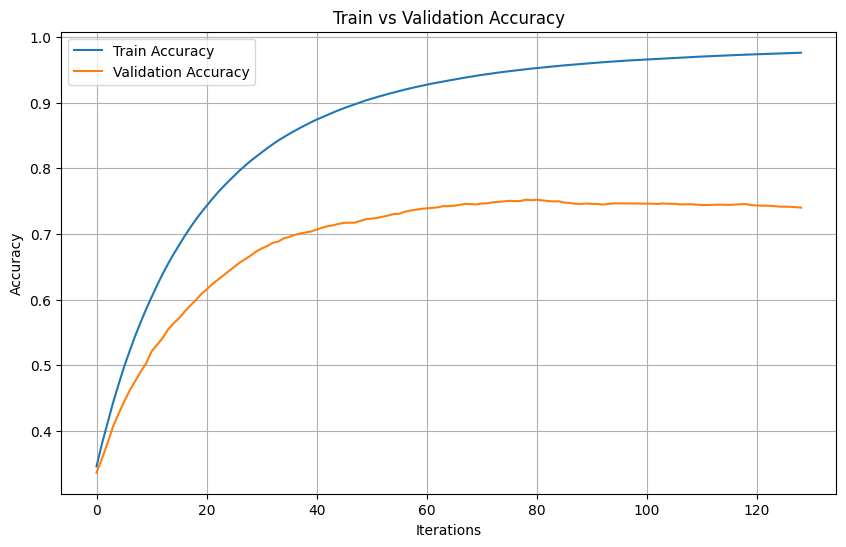

In [43]:
train_accuracy = [1 - x for x in train_logloss]  
val_accuracy = [1 - x for x in val_logloss]  

plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Feature Importance

In [44]:
import shap

In [ ]:
explainer = shap.Explainer(bst)
shap_values = explainer(X)  

In [ ]:
X.shape

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.waterfall(shap_values[1114])

In [ ]:
f_x = 3.242
p = 1 / (1 + np.exp(-f_x))
print(p)  # ≈ 0.9623

In [ ]:
df.groupby('ctr_group')[['Positive', 'Neutral', 'Negative', 'text_length', 'has_cta']].mean()

In [ ]:
combined_features.shape

In [ ]:
def get_feature_name(idx):
    meta_cols = ['text_length', 'has_cta', 'Positive', 'Negative', 'Neutral']
    if idx < 128:
        return f'image_feature_{idx}'
    elif idx < 1664:
        return f'text_embedding_{idx - 128}'
    elif idx < 1669:
        return meta_cols[idx - 1664]
    else:
        return 'Out of bounds'

In [ ]:
# shap_matrix = np.array([sv.values for sv in shap_values])  # (1115, 1669)

# df_shap = pd.DataFrame(shap_matrix, columns=[get_feature_name(i) for i in range(combined_features.shape[1])])
# df_shap['img_id'] = df['img_id'].values  

In [190]:
df_shap = pd.read_csv('/kaggle/input/df-shap/df_shap.csv')

In [191]:
df_shap

,image_feature_0,image_feature_1,image_feature_2,image_feature_3,image_feature_4,image_feature_5,image_feature_6,image_feature_7,image_feature_8,image_feature_9,...,text_embedding_764,text_embedding_765,text_embedding_766,text_embedding_767,text_embedding_768,text_embedding_769,text_embedding_770,text_embedding_771,img_id,ctr_group
0,-0.003812,0.002918,0.001801,-0.000829,0.023995,-0.002457,0.002827,-0.002166,-0.001025,-0.001260,...,0.0,0.000604,0.000550,0.0,0.0,-0.147022,0.0,-0.142443,c7e254ff6e829bbd379c791c06dba26a,Low
1,-0.023274,0.003912,0.000084,-0.005642,-0.002606,-0.002496,0.013001,0.001051,0.000527,0.000672,...,0.0,0.000604,0.000550,0.0,0.0,-0.146307,0.0,0.217544,310f05853aa67594eadcecfaeab260c9,Low
2,0.000745,0.002659,-0.002101,-0.000829,-0.002606,-0.002496,-0.001945,0.000576,0.000595,-0.001906,...,0.0,0.000604,0.000550,0.0,0.0,-0.152645,0.0,-0.145828,a602b8402e30353896de582cfc8602d6,Low
3,0.001030,-0.003884,0.003355,0.003363,-0.002606,-0.002457,-0.001016,0.001051,-0.000388,-0.000881,...,0.0,0.000604,0.000550,0.0,0.0,-0.148766,0.0,-0.128821,4eea40723af32721712529331dc268e8,Low
4,0.001030,-0.004505,-0.000437,0.003363,-0.002606,-0.002457,-0.001820,0.001051,0.000422,-0.000235,...,0.0,0.000604,0.000550,0.0,0.0,-0.153093,0.0,-0.172032,c863dc028d2446a5a578c77a2efa5806,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,0.003722,0.002320,0.007310,-0.000917,-0.000502,-0.000538,0.000019,-0.002081,-0.000857,0.001132,...,0.0,0.001144,0.000644,0.0,0.0,-0.034800,0.0,0.190033,e5a836a0356dc3b5949c00eb9ddb2c08,High
1111,0.001030,-0.021531,0.007172,0.001722,-0.000480,-0.000525,-0.000236,0.000373,-0.002821,0.003536,...,0.0,-0.001876,0.000324,0.0,0.0,-0.035097,0.0,-0.097311,62d04bf55fa25c0b1e4976346030997c,High
1112,0.003722,0.002157,0.004267,-0.000406,-0.000502,0.004744,-0.000590,0.000553,-0.000259,-0.000565,...,0.0,0.001063,0.000644,0.0,0.0,-0.033498,0.0,0.168935,f000a0f5e71a56d81262fe8bab8b2b5a,High
1113,0.001030,0.002875,-0.001899,-0.000318,-0.002606,-0.002496,0.003468,-0.002166,-0.000388,-0.001202,...,0.0,0.000604,0.000550,0.0,0.0,-0.141627,0.0,-0.146143,ca7337f25230b8c60291929edd36682e,Low


In [ ]:
df_shap_clean = df_shap.drop(columns=['img_id']).apply(pd.to_numeric, errors='coerce')

top_features = df_shap_clean.iloc[0].sort_values(ascending=False)
print(top_features.head(10))

In [ ]:
df_shap['ctr_group'] = df['ctr_group']

In [ ]:
df_shap['ctr_group'] = df_shap['ctr_group'].map({0:'Low', 1:'High'})

In [ ]:
df_shap

In [ ]:
# df_shap.to_csv('df_shap.csv', index=False)

In [ ]:
shap_high = df_shap[df_shap['ctr_group'] == 'High'].drop(columns=['img_id', 'ctr_group'])
shap_low = df_shap[df_shap['ctr_group'] == 'Low'].drop(columns=['img_id', 'ctr_group'])

In [ ]:
mean_shap_high = shap_high.mean()
mean_shap_low = shap_low.mean()

In [ ]:
shap_dif = (mean_shap_high - mean_shap_low).sort_values(ascending=False)

In [ ]:
shap_dif

In [ ]:
shap_dif.head(20).plot(kind='barh', title="Top Positive Features (High CTR vs Low CTR)")

In [ ]:
index = 1

In [ ]:
shap_values_row = df_shap.drop(columns=['img_id', 'ctr_group']).iloc[index]
top_n = 10  
shap_sorted = shap_values_row.abs().sort_values(ascending=False)[:top_n]

กราฟจะบอกว่า ฟีเจอร์ไหนดึง CTR ขึ้น (เขียว) หรือ ดึง CTR ลง (แดง) สำหรับรูปนั้น

In [ ]:
plt.figure(figsize=(10, 6))
shap_sorted_values = shap_values_row[shap_sorted.index]
colors = ['green' if val > 0 else 'red' for val in shap_sorted_values]

plt.barh(shap_sorted.index[::-1], shap_sorted_values[::-1], color=colors)
plt.xlabel("SHAP Value")
plt.title(f"Top {top_n} Features Impacting CTR (Image Index: {index})")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [45]:
images = torch.load("/kaggle/input/datath/datasetX3_reverse.pt")

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [46]:
def reverse_normalize(tensor_img):
    """
    ย้อน normalize จาก [-1, 1] → [0, 1]
    รองรับ Tensor shape (C, H, W) หรือ (N, C, H, W)
    """
    return (tensor_img * 0.5) + 0.5

In [47]:
images = reverse_normalize(images)

In [48]:
image = images[0].unsqueeze(0)

In [69]:
explainer = shap.TreeExplainer(bst, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X) 

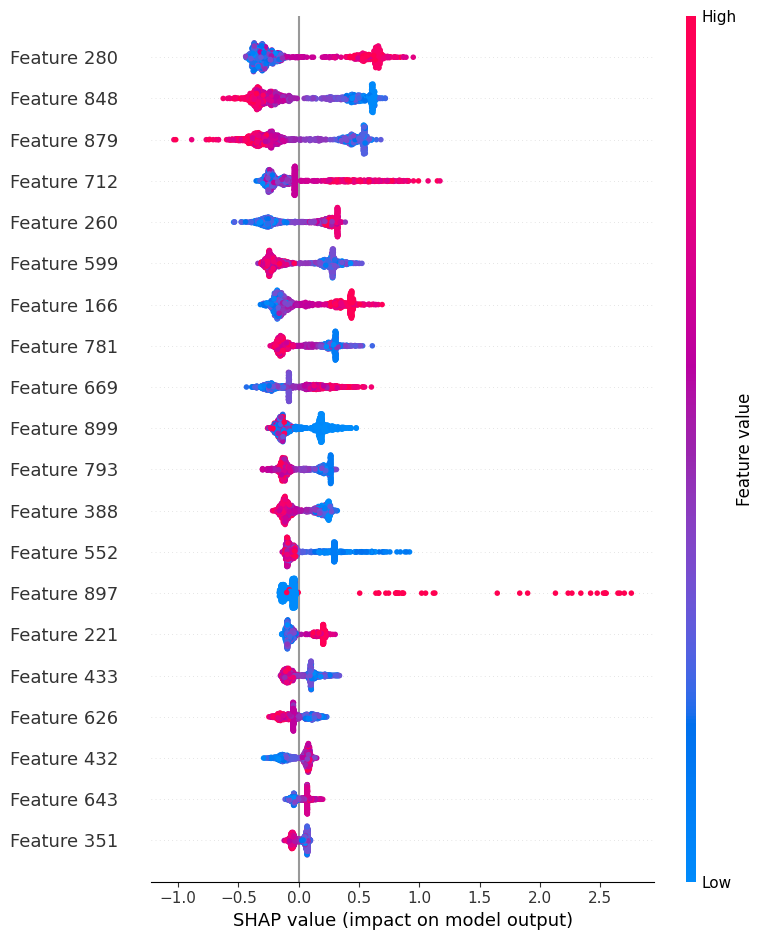

In [74]:
shap.summary_plot(shap_values, X)

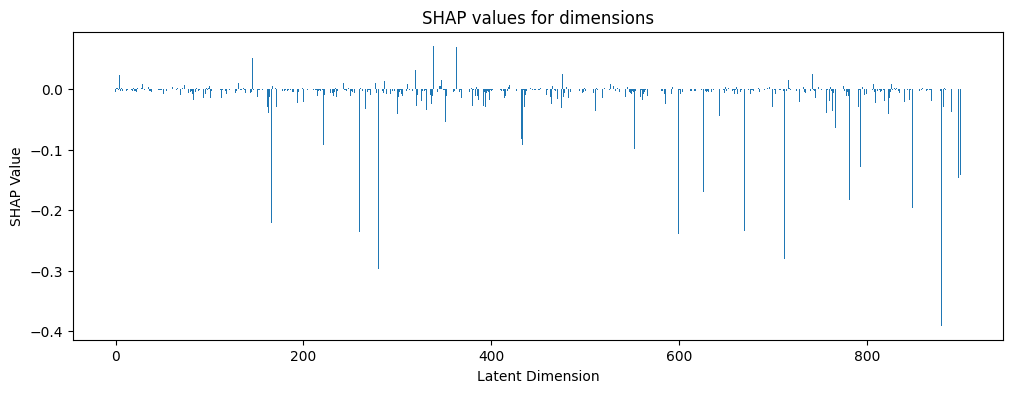

In [228]:
latent_dim = 900
latent_shap = shap_values[:, :latent_dim]

# Plot ค่า SHAP ในแต่ละ latent dimension
plt.figure(figsize=(12, 4))
plt.bar(range(latent_dim), latent_shap[0])  # สำหรับ sample แรก
plt.title("SHAP values for dimensions")
plt.xlabel("Latent Dimension")
plt.ylabel("SHAP Value")
plt.show()

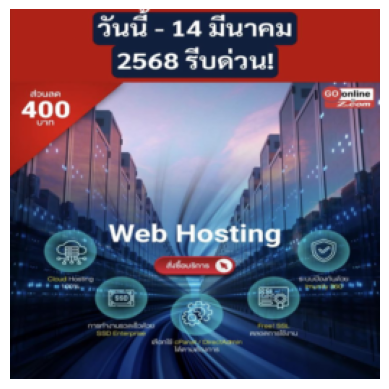

In [83]:
image_to_display = image.squeeze().permute(1, 2, 0).cpu().numpy()

plt.imshow(image_to_display)
plt.axis('off')  
plt.show()

In [218]:
def reverse_normalize(tensor_img):
    """
    Reverse normalization from [-1, 1] → [0, 1]
    Supports Tensor shape (C, H, W) or (N, C, H, W)
    """
    return (tensor_img * 0.5) + 0.5

In [219]:
def load_image_data(file_path):
    """Load image tensor data from .pt file and reverse normalize"""
    try:
        images = torch.load(file_path)
        print(f"Successfully loaded image data with shape: {images.shape}")
        # Apply reverse normalization to bring values from [-1, 1] to [0, 1]
        images = reverse_normalize(images)
        return images
    except Exception as e:
        print(f"Error loading image data: {e}")
        return None

In [241]:
def visualize_importance(image_tensor, shap_df, image_idx=0, threshold=0.5):
    """
    Visualize important areas of an image based on Shap values
    
    Args:
        image_tensor: Tensor containing images
        shap_df: DataFrame with Shap values
        image_idx: Index of the image to visualize
        threshold: Threshold for importance, features above this are highlighted
    """
    # Get the image
    if len(image_tensor.shape) == 4:  # Batch, Channel, Height, Width
        image = image_tensor[image_idx].permute(1, 2, 0)  # Change to H, W, C for display
    else:
        image = image_tensor

    # Convert to numpy and ensure it's in 0-1 range
    if torch.is_tensor(image):
        # Ensure the image is in [0,1] range
        image_np = image.numpy()
    else:
        image_np = image
    
    # If image has only one channel, duplicate it to make an RGB image
    if len(image_np.shape) == 2 or image_np.shape[2] == 1:
        if len(image_np.shape) == 2:
            image_np = np.stack([image_np, image_np, image_np], axis=2)
        else:
            image_np = np.concatenate([image_np] * 3, axis=2)
    
    # Get image dimensions
    height, width = image_np.shape[0], image_np.shape[1]
    
    # Extract important regions from Shap values
    # For demonstration, let's create a heatmap based on the top features
    # In a real implementation, this would use the actual feature to pixel mapping
    
    # Sort features by absolute Shap value
    if 'shap_value' in shap_df.columns:
        important_features = shap_df.sort_values(by='shap_value', ascending=False)
    else:
        # If no column is named 'shap_value', use the first numeric column
        numeric_cols = shap_df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            important_features = shap_df.sort_values(by=numeric_cols[0], ascending=False)
        else:
            print("No numeric columns found in Shap DataFrame")
            return

    # Create a mask for important regions
    # Here we're simulating regions based on feature importance
    # In a real implementation, you'd map features directly to image regions
    mask = np.zeros((height, width))
    
    # Create importance regions based on top features
    num_top_features = min(5, len(important_features))
    for i in range(num_top_features):
        # Generate a region (this is a simulation - you would use actual feature locations)
        # This creates rectangles of different sizes at different locations
        h_start = int(np.random.uniform(0, height * 0.5))
        w_start = int(np.random.uniform(0, width * 0.5))
        h_size = int(np.random.uniform(height * 0.2, height * 0.5))
        w_size = int(np.random.uniform(width * 0.2, width * 0.5))
        
        h_end = min(h_start + h_size, height)
        w_end = min(w_start + w_size, width)
        
        # Assign importance value to this region
        importance_value = 1.0 - (i / num_top_features)
        mask[h_start:h_end, w_start:w_end] = importance_value
    
    # Create a custom colormap for the overlay: transparent -> red
    colors = [(1, 0, 0, 0), (1, 0, 0, 0.7)]  # Transparent to semi-transparent red
    cmap = LinearSegmentedColormap.from_list('importance_cmap', colors, N=100)
    
    # Create the visualization
    plt.figure(figsize=(12, 6))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')
    
    # Plot image with importance overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image_np)
    plt.imshow(mask, cmap=cmap, alpha=1.0)
    plt.title("Image with Importance Overlay")
    plt.axis('off')
    
    # Add a colorbar to indicate importance
    plt.colorbar(label='Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    return mask  # Return the mask for further processing if needed

In [242]:
def create_bounding_boxes(image_tensor, shap_df, image_idx=0, threshold=0.5):
    """
    Create an image with bounding boxes around important regions
    
    Args:
        image_tensor: Tensor containing images
        shap_df: DataFrame with Shap values
        image_idx: Index of the image to visualize
        threshold: Threshold for importance, features above this are highlighted
    """
    # Get the image
    if len(image_tensor.shape) == 4:  # Batch, Channel, Height, Width
        image = image_tensor[image_idx].permute(1, 2, 0)  # Change to H, W, C for display
    else:
        image = image_tensor

    # Convert to numpy and ensure it's in 0-1 range
    if torch.is_tensor(image):
        # Ensure the image is in [0,1] range
        image_np = image.numpy()
    else:
        image_np = image
    
    # Scale to 0-255 for PIL
    image_np = (image_np * 255).astype(np.uint8)
    
    # If image has only one channel, duplicate it to make an RGB image
    if len(image_np.shape) == 2:
        image_np = np.stack([image_np, image_np, image_np], axis=2)
    elif image_np.shape[2] == 1:
        image_np = np.concatenate([image_np] * 3, axis=2)
    
    # Get image dimensions
    height, width = image_np.shape[0], image_np.shape[1]
    
    # Create PIL image for drawing
    pil_image = Image.fromarray(image_np)
    draw = ImageDraw.Draw(pil_image)
    
    # Sort features by absolute Shap value
    if 'shap_value' in shap_df.columns:
        important_features = shap_df.sort_values(by='shap_value', ascending=False)
    else:
        # If no column is named 'shap_value', use the first numeric column
        numeric_cols = shap_df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            important_features = shap_df.sort_values(by=numeric_cols[0], ascending=False)
        else:
            print("No numeric columns found in Shap DataFrame")
            return pil_image
    
    # Draw bounding boxes for top features
    num_top_features = min(5, len(important_features))
    for i in range(num_top_features):
        # Generate a region (this is a simulation - you would use actual feature locations)
        h_start = int(np.random.uniform(0, height * 0.5))
        w_start = int(np.random.uniform(0, width * 0.5))
        h_size = int(np.random.uniform(height * 0.2, height * 0.5))
        w_size = int(np.random.uniform(width * 0.2, width * 0.5))
        
        # Calculate boundary
        box = [(w_start, h_start), (w_start + w_size, h_start + h_size)]
        
        # Calculate color based on importance (red with varying opacity)
        importance_value = 1.0 - (i / num_top_features)
        color_intensity = int(255 * importance_value)
        box_color = (255, 0, 0, color_intensity)  # Red with varying opacity
        
        # Draw rectangle
        draw.rectangle(box, outline=box_color, width=3)
        
        # Add small label
        label_text = f"F{i+1}: {importance_value:.2f}"
        draw.text((box[0][0], box[0][1] - 15), label_text, fill=(255, 0, 0))
    
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(np.array(pil_image))
    plt.title("Image with Important Regions Highlighted")
    plt.axis('off')
    plt.show()
    
    return pil_image

In [236]:
import random

In [243]:
def main():
    # Load image data from .pt file
    image_data = load_image_data("/kaggle/input/datath/datasetX3_reverse.pt")
    
    # For demonstration, create a synthetic Shap DataFrame if the real one isn't available
    # In actual use, you would use your df_shap dataframe
    try:
        # Check if df_shap variable exists in the environment
        shap_df = df_shap
        print("Using available Shap DataFrame")
    except NameError:
        print("Creating synthetic Shap DataFrame for demonstration")
        # Create synthetic data for demonstration
        features = [f"feature_{i}" for i in range(20)]
        shap_values = np.random.randn(20)
        shap_df = pd.DataFrame({
            'feature': features,
            'shap_value': shap_values
        })
    
    # if image_data is not None:
    #     num_images = min(5, len(image_data))  
    #     for i in range(num_images):
    #         print(f"Visualizing image index {i}")
    #         visualize_importance(image_data, shap_df, image_idx=i)
    # else:
    #     print("Could not load image data")
    
    if image_data is not None:
        num_images = min(5, len(image_data))  # จำนวนภาพที่ต้องการสุ่มแสดง
        random_indices = random.sample(range(len(image_data)), num_images)  # สุ่ม index ไม่ซ้ำกัน

    for i in random_indices:
        print(f"Visualizing image index {i}")
        visualize_importance(image_data, shap_df, image_idx=i)
    else:
        print("Could not load image data")

Successfully loaded image data with shape: torch.Size([1115, 3, 256, 256])
Using available Shap DataFrame
Visualizing image index 222


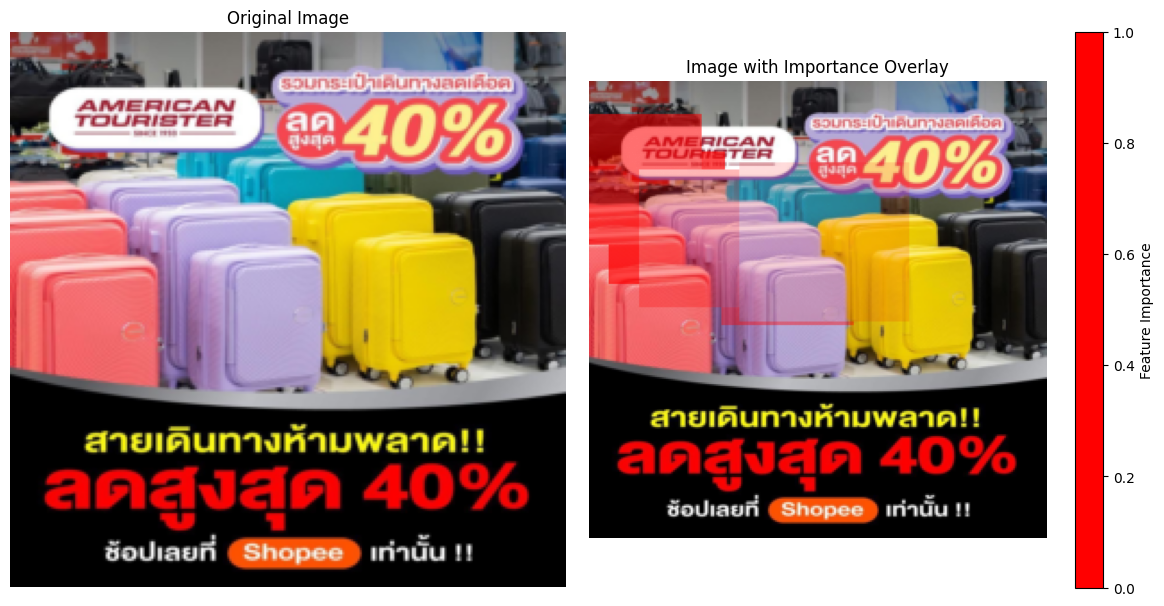

Visualizing image index 1092


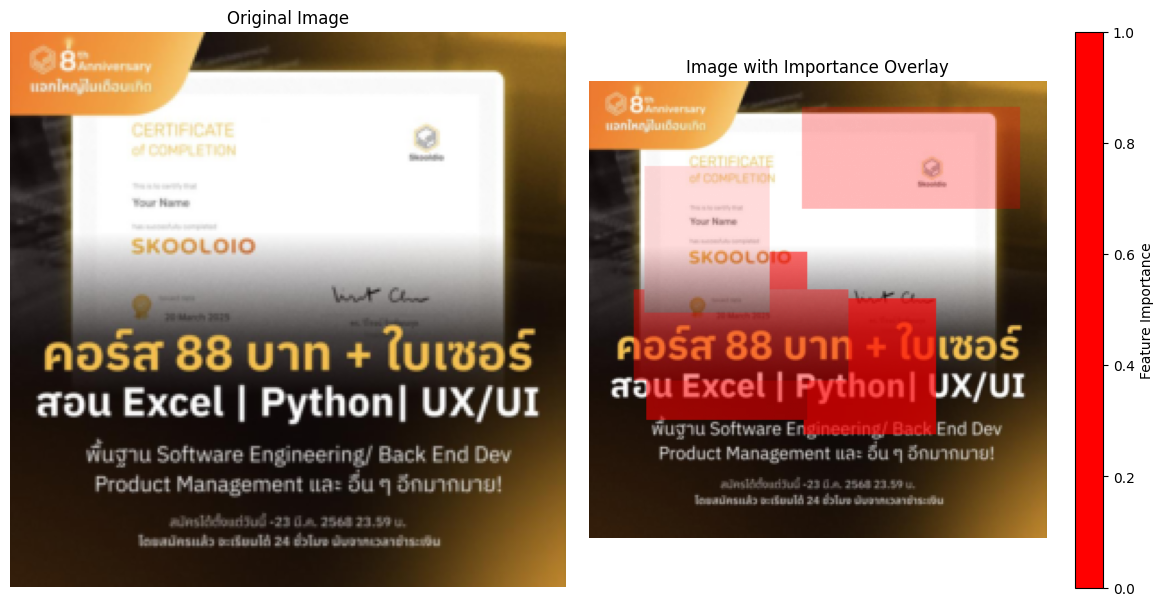

Visualizing image index 1003


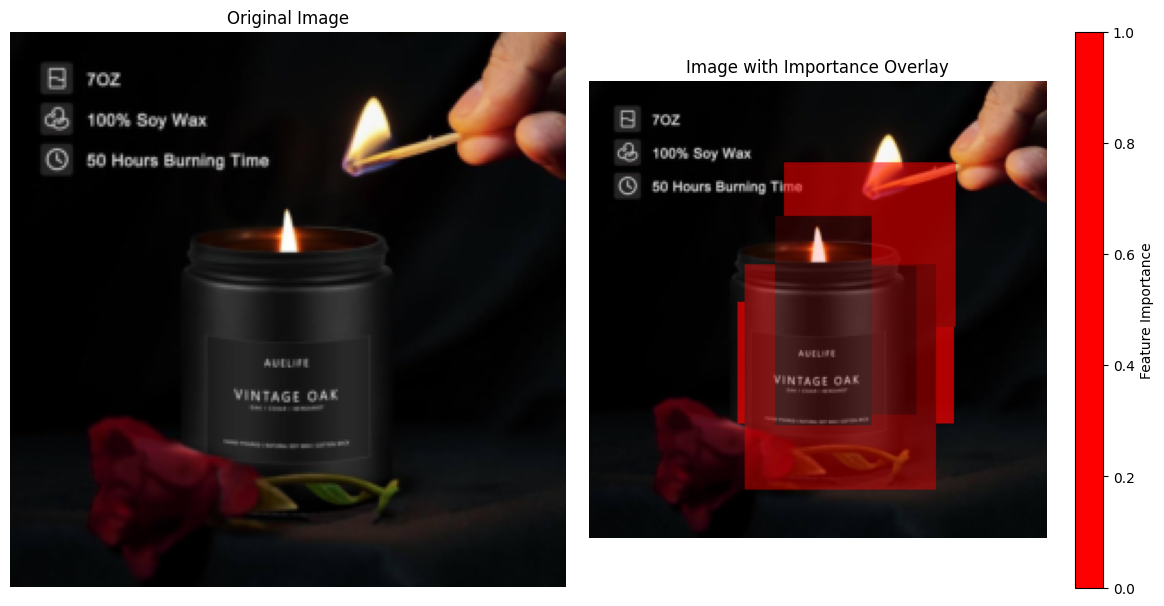

Visualizing image index 81


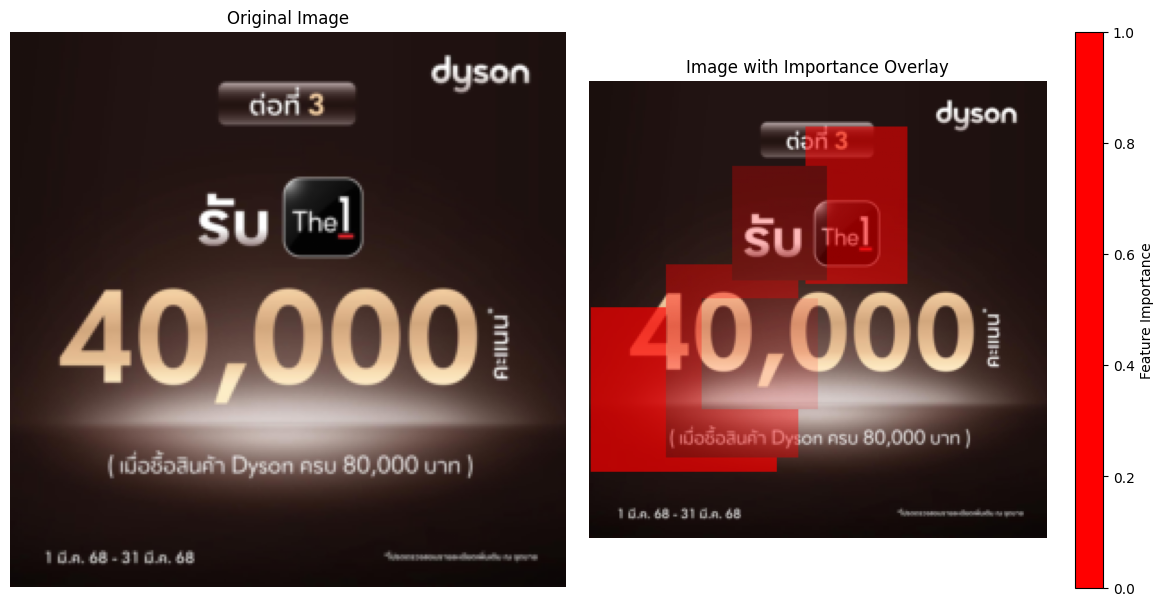

Visualizing image index 880


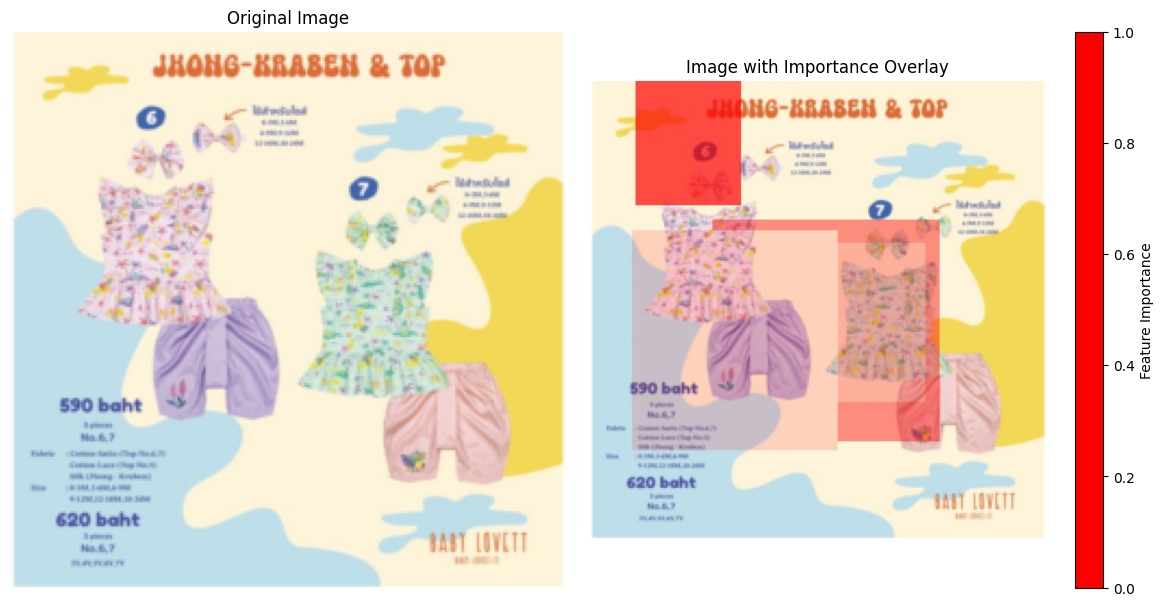

Could not load image data


In [244]:
if __name__ == "__main__":
    main()